# Evaluación del modelo SIFT



In [1]:
!pwd

/home/mario/Documents/ScenesRecognition-AYUDAME/BoVW


In [2]:
from BoVW import getBoVWRepresentation
from Image_Descriptor import *
import cv2 as cv
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import GridSearchCV
from joblib import dump, load

## Carga del modelo y del codebook

In [3]:
model = load("model_sift_01.joblib")
stdSlr = load("standard_scaler_sift_01.joblib")
codebook = np.load("codebook_sift_01.npy")

In [4]:
model.get_params()

{'C': 0.01,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [5]:
stdSlr.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

In [6]:
codebook.shape

(1024, 128)

## Extracción de características de muestras de prueba

In [7]:
dataset_path = "../Proyecto_AYUDAME_Datasets/Microsoft_7scenes_rgb_seq-02"
filenames,label_ids,labels = prepareFiles(dataset_path)

In [8]:
# Encuentra las etiquetas distintas
labels_uk = np.unique(labels)

### Obtención de los descriptores de los datos de prueba

In [9]:
descriptor = cv.SIFT_create()

In [10]:
kpts_val,dscs_val = getKeypointsDescriptors(filenames,descriptor)

Extracting Local Descriptors


100%|██████████| 6500/6500 [10:22<00:00, 10.44it/s]

Done in 622.7325141429901 secs.


Se almacenan los descriptores porque su extracción es un proceso **altamente pesado**.

No se almacena la lista de puntos clave porque es una lista de objetos complejos que no se permiten serializar directamente, además, el método de BoVW simple (el método que se utilizará en este notebook) solo utiliza la lista de descriptores, no la de puntos clave, por lo que no es necesaria.  En caso de requerirse almacenar la lista de puntos clave se debe representar cada punto clave como una tupla con las propiedades de dichos puntos clave, tal como se realiza en este post https://stackoverflow.com/questions/10045363/pickling-cv2-keypoint-causes-picklingerror/11985056#11985056.

In [11]:
# Para almacenar se usa dump
# dump(dscs_val, "dscs_val_01.joblib")

['dscs_val_01.joblib']

In [9]:
# En caso de requerir leer el archivo almacenado
dscs_val = load("dscs_val_01.joblib")

Se revisa el número de descriptores de entrenamiento

In [12]:
dscs_val_np = np.vstack(dscs_val)
dscs_val_np.shape

(4840409, 128)

## Preprocesamiento de los datos

Se obtiene la representación BoVW

In [10]:
vw_val = getBoVWRepresentation(dscs_val,codebook)
vw_val.shape

Extracting visual word representations
Done in 50.716509103775024 secs.


(6500, 1024)

Se estandarizan los datos de prueba

In [11]:
val = vw_val
val = stdSlr.transform(val)

## Evaluación de resultados

Exactitud del modelo

In [12]:
y_val = label_ids # valores reales
acc = 100*model.score(val, y_val)
print(f"La exatitud del modelo es: {acc}")

La exatitud del modelo es: 85.07692307692307


In [13]:
val_pred = model.predict(val)

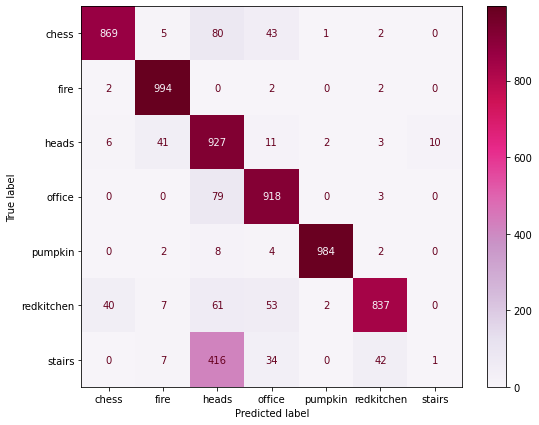

In [14]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=y_val,y_pred=val_pred,
                                              ax=ax,cmap='PuRd',display_labels=labels_uk)
plt.show()

In [15]:
print(classification_report(y_true=y_val,y_pred=val_pred))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1000
           1       0.94      0.99      0.97      1000
           2       0.59      0.93      0.72      1000
           3       0.86      0.92      0.89      1000
           4       0.99      0.98      0.99      1000
           5       0.94      0.84      0.89      1000
           6       0.09      0.00      0.00       500

    accuracy                           0.85      6500
   macro avg       0.77      0.79      0.77      6500
weighted avg       0.82      0.85      0.82      6500

